In [1]:
import numpy as np
import seaborn as sns
import copy
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.colors import SymLogNorm
from matplotlib import cm
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import os

from ClusterModel.model import Cluster as CM
from ClusterModel.ClusterTools import cluster_electron_loss as cel

mycol = sns.color_palette("husl", 10)
mycol = sns.hls_palette(5, l=.4, s=1)

dict_base = {'font.size':        16, 
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             #'axes.prop_cycle': cycler('color', mycol),
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15, # Ensure enough space on the left so that all plot can be aligned
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

figdir = '/Users/adam/Project/Notes-Papier-Conf/TMP_MINOS/Figure'

In [2]:
cluster = CM(name='Cluster', redshift=0.02, M500=7e14*u.Msun, output_dir=os.getenv('CTAPHYS_OUT_DIR')+'/MINOS_demo', silent=True)

cluster.R_truncation = 4*cluster.R500

cluster.density_gas_model = {'name':'SVM', 'beta':0.6, 'r_c':290*u.kpc, 'n_0':2.3e-3*u.cm**-3, 'r_s':1000*u.kpc, 'gamma':3, 'epsilon':1.7, 'alpha':0.0}
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':2.0e-2*u.keV/u.cm**3,'a':1.5,'b':3.1,'c':0.00,'c500':3.2}
cluster.set_magfield_isodens_scal_param(5*u.uG, scal=0.5)

cluster.set_density_crp_isobaric_scal_param(scal=0.6)
cluster.set_density_cre1_isodens_scal_param(scal=0.6)
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.4}
cluster.spectrum_cre1_model = {'name':'ContinuousInjection', 'Index':2.3, 'BreakEnergy':5*u.GeV}
cluster.cre1_loss_model = 'None'

cluster.Eemin = 1*u.MeV
cluster.X_cre1_E = {'X':1e-5, 'R_norm':cluster.R500}
cluster.X_crp_E = {'X':1e-2, 'R_norm':cluster.R500}

cluster.map_fov = 6*u.deg
cluster.Npt_per_decade_integ = 50

# Profiles and spectra

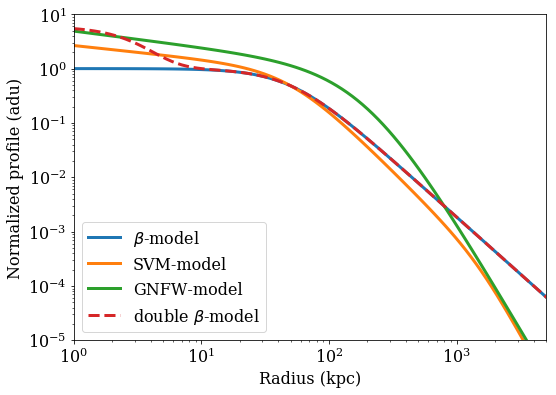

In [3]:
r = np.logspace(0,4,100)*u.kpc

p1 = cluster._get_generic_profile(r, {'name':'beta', 'n_0':1.0*u.cm**-3, 'r_c':50*u.kpc, 'beta':0.7})
p2 = cluster._get_generic_profile(r, {'name':'SVM', 'n_0':1.0*u.cm**-3, 'r_c':50*u.kpc, 'beta':0.7, 'r_s':1500*u.kpc, 'gamma':3, 'epsilon':4.0, 'alpha':0.5})
p3 = cluster._get_generic_profile(r, {'name':'GNFW', 'P_0':1.0*u.cm**-3, 'r_p':200*u.kpc, 'a':1.5, 'b':4, 'c':0.3})
p4 = cluster._get_generic_profile(r, {'name':'doublebeta', 'n_01':1.0*u.cm**-3, 'r_c1':50*u.kpc, 'beta1':0.7, 'n_02':5.0*u.cm**-3, 'r_c2':5*u.kpc, 'beta2':2.0})

plt.figure(figsize=(8,6))
plt.loglog(r, p1, label='$\\beta$-model', linewidth=3)
plt.loglog(r, p2, label='SVM-model', linewidth=3)
plt.loglog(r, p3, label='GNFW-model', linewidth=3)
plt.loglog(r, p4, label='double $\\beta$-model', linewidth=3, linestyle='--')
plt.xlabel('Radius (kpc)')
plt.ylabel('Normalized profile (adu)')
plt.xlim(1, 5e3)
plt.ylim(1e-5, 1e1)
plt.legend()
plt.savefig(figdir+'/profiles.pdf')

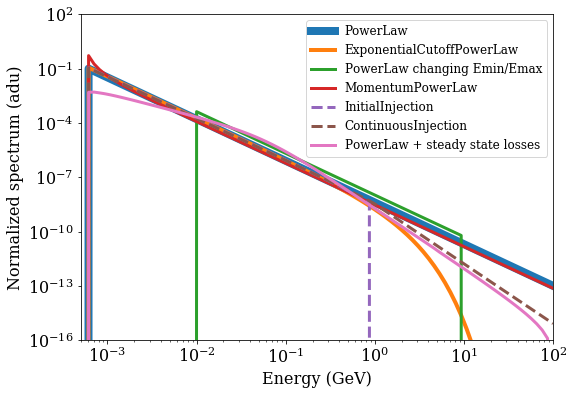

In [4]:
E = np.logspace(-4,2,100)*u.GeV

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'PowerLaw', 'Index':2.3}
ctmp.cre1_loss_model = 'None'
s1 = ctmp.get_cre1_spectrum(E)[1]
norm = 10*np.amax(s1)
s1 = s1/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':2.3, 'CutoffEnergy':1*u.GeV}
ctmp.cre1_loss_model = 'None'
s2 = ctmp.get_cre1_spectrum(E)[1]
s2 = s2/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin=10*u.MeV
ctmp.Eemax=10*u.GeV
ctmp.spectrum_cre1_model = {'name':'PowerLaw', 'Index':2.3}
ctmp.cre1_loss_model = 'None'
s3 = ctmp.get_cre1_spectrum(E)[1]
s3 = s3/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_e*const.c**2}
ctmp.cre1_loss_model = 'None'
s4 = ctmp.get_cre1_spectrum(E)[1]
s4 = s4/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'InitialInjection', 'Index':2.3, 'BreakEnergy':1*u.GeV}
ctmp.cre1_loss_model = 'None'
s5 = ctmp.get_cre1_spectrum(E)[1]
s5 = s5/norm

ctmp = copy.deepcopy(cluster)
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'ContinuousInjection', 'Index':2.3, 'BreakEnergy':1*u.GeV}
ctmp.cre1_loss_model = 'None'
s6 = ctmp.get_cre1_spectrum(E)[1]
s6 = s6/norm

ctmp = copy.deepcopy(cluster)
ctmp.Npt_per_decade_integ = 100
ctmp.cre1_loss_model = 'Steady'
ctmp.Eemin = const.m_e*const.c**2+100*u.keV
ctmp.Eemax = 100*u.GeV
ctmp.spectrum_cre1_model = {'name':'PowerLaw', 'Index':2.3}
s7 = ctmp.get_cre1_spectrum(E)[1]
s7 = s7/norm

plt.figure(figsize=(8,6))
plt.loglog(E, s1, label='PowerLaw', linewidth=8)
plt.loglog(E, s2, label='ExponentialCutoffPowerLaw', linewidth=4)
plt.loglog(E, s3, label='PowerLaw changing Emin/Emax', linewidth=3)
plt.loglog(E, s4, label='MomentumPowerLaw', linewidth=3, linestyle='-')
plt.loglog(E, s5, label='InitialInjection', linewidth=3, linestyle='--')
plt.loglog(E, s6, label='ContinuousInjection', linewidth=3, linestyle='--')
plt.loglog(E, s7, label='PowerLaw + steady state losses', linewidth=3, linestyle='-')
plt.xlabel('Energy (GeV)')
plt.ylabel('Normalized spectrum (adu)')
plt.xlim(5e-4, 1e2)
plt.ylim(1e-16, 100)
plt.legend(fontsize=12, loc='upper right')
plt.savefig(figdir+'/spectra.pdf')

# Thermodynamics

/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


(0.21330061679555268, <Quantity 7.e+14 solMass>)

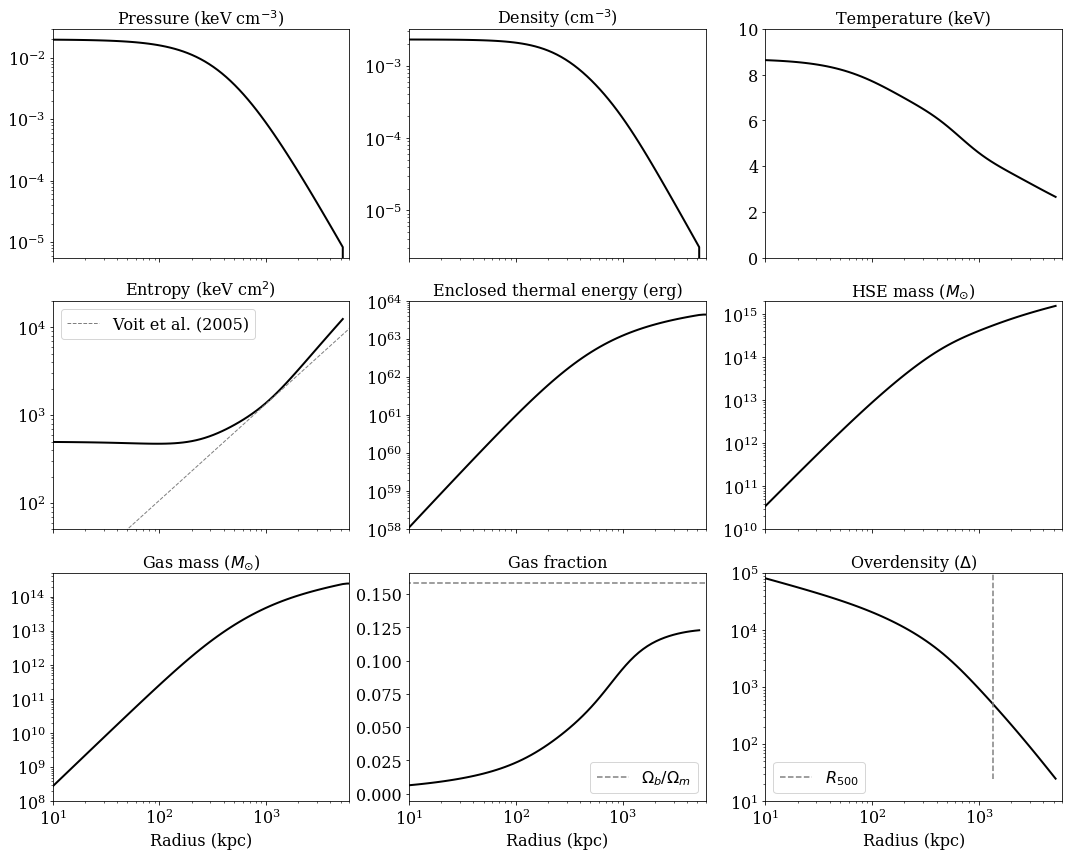

In [5]:
r = np.logspace(0,4,100)*u.kpc

f_b = cluster.cosmo.Ob0 / cluster.cosmo.Om0
k500 = 106.0 * (cluster.M500.to_value('Msun')/1e14*cluster.cosmo.H0.value/70.0)**(2.0/3.0) * (1.0/f_b)**(2.0/3.0) * cluster.cosmo.efunc(cluster.redshift)**(-2./3.0) * (cluster.cosmo.H0.value/70.0)**(-4.0/3.0)
blk = 1.42*k500*(r.to_value('kpc') / cluster.R500.to_value('kpc'))**1.1

Pe  = cluster.get_pressure_gas_profile(r)[1]
ne  = cluster.get_density_gas_profile(r)[1]
T   = cluster.get_temperature_gas_profile(r)[1]
K   = cluster.get_entropy_gas_profile(r)[1]
Uth = cluster.get_thermal_energy_profile(r)[1]
Mhse = cluster.get_hse_mass_profile(r)[1]
Mgas = cluster.get_gas_mass_profile(r)[1]
fgas = cluster.get_fgas_profile(r)[1]
od   = cluster.get_overdensity_contrast_profile(r)[1]
R500, M500 = cluster.get_mdelta_from_profile()

fig, ax = plt.subplots(3,3,figsize=(15,12), sharex=True)
ax[0,0].loglog(r, Pe, linewidth=2, color='k')
ax[0,0].set_title('Pressure (keV cm$^{-3}$)')
ax[0,1].loglog(r, ne, linewidth=2, color='k')
ax[0,1].set_title('Density (cm$^{-3}$)')
ax[0,2].plot(r, T, linewidth=2, color='k')
ax[0,2].set_title('Temperature (keV)')
ax[0,2].set_ylim(0,10)

ax[1,0].loglog(r, K, linewidth=2, color='k')
ax[1,0].loglog(r, blk, linewidth=1, linestyle='--', color='grey', label='Voit et al. (2005)')
ax[1,0].set_title('Entropy (keV cm$^{2}$)')
ax[1,0].set_ylim(50, 2e4)
ax[1,0].legend()
ax[1,1].loglog(r, Uth, linewidth=2, color='k')
ax[1,1].set_title('Enclosed thermal energy (erg)')
ax[1,1].set_ylim(1e58,1e64)
ax[1,2].loglog(r, Mhse, linewidth=2, color='k')
ax[1,2].set_title('HSE mass ($M_{\odot}$)')
ax[1,2].set_ylim(1e10,2e15)

ax[2,0].loglog(r, Mgas, linewidth=2, color='k')
ax[2,0].set_title('Gas mass ($M_{\odot}$)')
ax[2,0].set_ylim(1e8,5e14)
ax[2,1].plot(r, fgas, linewidth=2, color='k')
ax[2,1].plot([np.amin(r.value), np.amax(r.value)], [f_b, f_b], linestyle='--', label='$\\Omega_b / \\Omega_m$', color='grey')
ax[2,1].set_title('Gas fraction')
ax[2,1].legend()
ax[2,2].loglog(r, od, linewidth=2, color='k')
ax[2,2].set_title('Overdensity ($\\Delta$)')
ax[2,2].plot([R500.to_value('kpc'),R500.to_value('kpc')], [np.nanmin(od.value), np.nanmax(od.value)], linestyle='--', label='$R_{500}$', color='grey')
ax[2,2].legend()
ax[2,2].set_ylim(10,1e5)

ax[2,0].set_xlabel('Radius (kpc)')
ax[2,1].set_xlabel('Radius (kpc)')
ax[2,2].set_xlabel('Radius (kpc)')
ax[2,2].set_xlim(10,6000)

fig.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()
plt.savefig(figdir+'/thermodynamic_profiles.pdf')

cluster.set_hsebias_from_m500_and_mhse()
cluster.hse_bias, cluster.M500

# Non-thermal properties

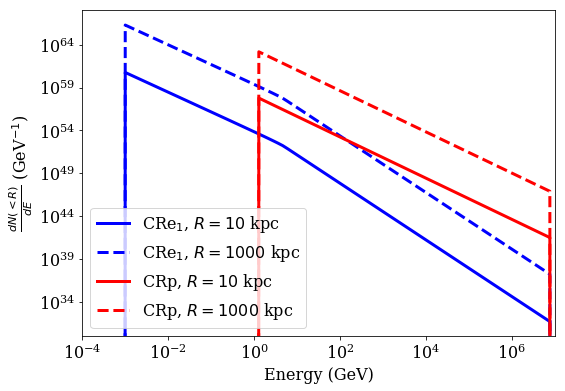

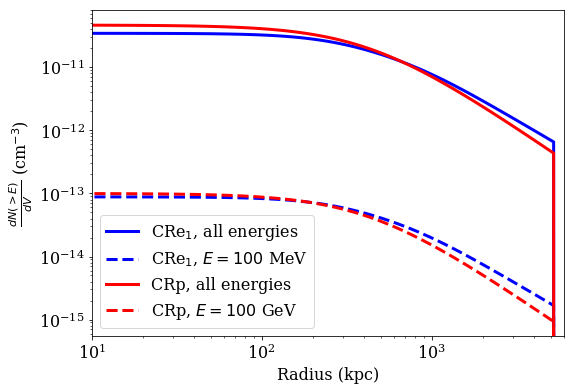

In [20]:
e = np.logspace(-4,7,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

ncre1_10 = cluster.get_cre1_spectrum(e, Rmax=10*u.kpc)[1]
ncrp_10  = cluster.get_crp_spectrum(e, Rmax=10*u.kpc)[1]
ncre1_1000 = cluster.get_cre1_spectrum(e, Rmax=1000*u.kpc)[1]
ncrp_1000  = cluster.get_crp_spectrum(e, Rmax=1000*u.kpc)[1]

plt.figure(0, figsize=(8,6))
plt.loglog(e, ncre1_10.to_value('GeV-1'), linewidth=3, color='blue', label='CRe$_1$, $R=10$ kpc')
plt.loglog(e, ncre1_1000.to_value('GeV-1'), linewidth=3, color='blue', linestyle='--', label='CRe$_1$, $R=1000$ kpc')
plt.loglog(e, ncrp_10.to_value('GeV-1'), linewidth=3, color='red', label='CRp, $R=10$ kpc')
plt.loglog(e, ncrp_1000.to_value('GeV-1'), linewidth=3, color='red', linestyle='--', label='CRp, $R=1000$ kpc')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{dN(<R)}{dE}$ (GeV$^{-1}$)')
plt.xlim(1e-4,1e7)
plt.legend()
plt.savefig(figdir+'/nonthermal_spectra.pdf')

ncre1_1 = cluster.get_density_cre1_profile(r, Emin=const.m_e*const.c**2)[1]
ncre1_2  = cluster.get_density_cre1_profile(r, Emin=100*u.MeV)[1]
ncrp_1 = cluster.get_density_crp_profile(r, Emin=const.m_p*const.c**2)[1]
ncrp_2  = cluster.get_density_crp_profile(r, Emin=100*u.GeV)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, ncre1_1.to_value('cm-3'), linewidth=3, color='blue', label='CRe$_1$, all energies')
plt.loglog(r, ncre1_2.to_value('cm-3'), linewidth=3, color='blue', linestyle='--', label='CRe$_1$, $E=100$ MeV')
plt.loglog(r, ncrp_1.to_value('cm-3'), linewidth=3, color='red', label='CRp, all energies')
plt.loglog(r, ncrp_2.to_value('cm-3'), linewidth=3, color='red', linestyle='--', label='CRp, $E=100$ GeV')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN(>E)}{dV}$ (cm$^{-3}$)')
plt.xlim(10,6000)
plt.legend(loc='lower left')
plt.savefig(figdir+'/nonthermal_profile.pdf')

# Production rate of particles

/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


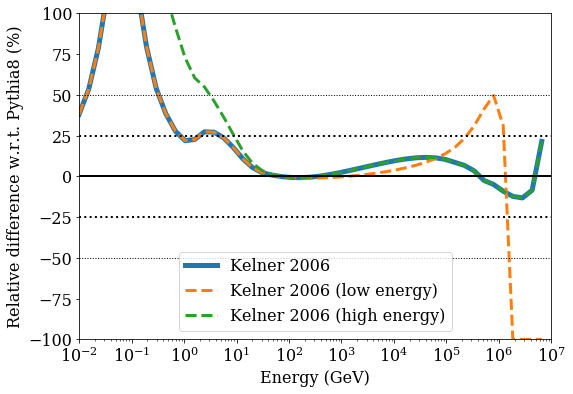

In [7]:
# Comparison between Kelner and Kafexhiu
e = np.logspace(-2,7,50)*u.GeV
ctmp = copy.deepcopy(cluster)
r = 100*u.kpc
ctmp.abundance = 0.0
ctmp.helium_mass_fraction = 0.0

dNdEdVdt1 = ctmp.get_rate_gamma(energy=e,radius=r, model='Kafexhiu2014')[:,0]
dNdEdVdt2 = ctmp.get_rate_gamma(energy=e,radius=r, model='Kelner2006', limit='mixed')[:,0]
dNdEdVdt3 = ctmp.get_rate_gamma(energy=e,radius=r, model='Kelner2006', limit='lowE')[:,0]
dNdEdVdt4 = ctmp.get_rate_gamma(energy=e,radius=r, model='Kelner2006', limit='highE')[:,0]

plt.figure(figsize=(8,6))
plt.plot(e, 100*(dNdEdVdt2-dNdEdVdt1)/dNdEdVdt1, label='Kelner 2006', linewidth=5)
plt.plot(e, 100*(dNdEdVdt3-dNdEdVdt1)/dNdEdVdt1, label='Kelner 2006 (low energy)', linewidth=3, linestyle='--')
plt.plot(e, 100*(dNdEdVdt4-dNdEdVdt1)/dNdEdVdt1, label='Kelner 2006 (high energy)', linewidth=3, linestyle='--')
plt.plot(e, e.value*0, linewidth=2, linestyle='-', color='k')
plt.plot(e, e.value*0+25, linewidth=2, linestyle=':', color='k')
plt.plot(e, e.value*0-25, linewidth=2, linestyle=':', color='k')
plt.plot(e, e.value*0+50, linewidth=1, linestyle=':', color='k')
plt.plot(e, e.value*0-50, linewidth=1, linestyle=':', color='k')
plt.xlabel('Energy (GeV)')
plt.ylabel('Relative difference w.r.t. Pythia8 (%)')
plt.xscale('log')
plt.xlim(1e-2, 1e7)
plt.ylim(-100,100)
plt.legend()
plt.savefig(figdir+'/prodrate1.pdf')

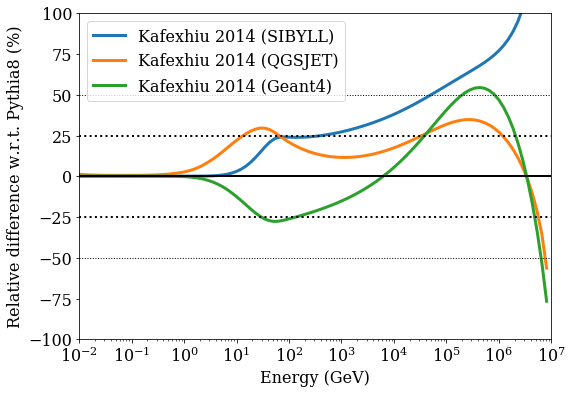

In [8]:
# Impact of the particle physics data
e = np.logspace(-2,7,100)*u.GeV
ctmp = copy.deepcopy(cluster)
r = 100*u.kpc

ctmp.pp_interaction_model = 'Pythia8'
dNdEdVdt1 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.pp_interaction_model = 'SIBYLL'
dNdEdVdt2 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.pp_interaction_model = 'QGSJET'
dNdEdVdt3 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.pp_interaction_model = 'Geant4'
dNdEdVdt4 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]

plt.figure(figsize=(8,6))
plt.plot(e, 100*(dNdEdVdt2-dNdEdVdt1)/dNdEdVdt1, label='Kafexhiu 2014 (SIBYLL)', linewidth=3)
plt.plot(e, 100*(dNdEdVdt3-dNdEdVdt1)/dNdEdVdt1, label='Kafexhiu 2014 (QGSJET)', linewidth=3)
plt.plot(e, 100*(dNdEdVdt4-dNdEdVdt1)/dNdEdVdt1, label='Kafexhiu 2014 (Geant4)', linewidth=3)
plt.plot(e, e.value*0, linewidth=2, linestyle='-', color='k')
plt.plot(e, e.value*0+25, linewidth=2, linestyle=':', color='k')
plt.plot(e, e.value*0-25, linewidth=2, linestyle=':', color='k')
plt.plot(e, e.value*0+50, linewidth=1, linestyle=':', color='k')
plt.plot(e, e.value*0-50, linewidth=1, linestyle=':', color='k')
plt.xlabel('Energy (GeV)')
plt.ylabel('Relative difference w.r.t. Pythia8 (%)')
plt.xscale('log')
plt.xlim(1e-2, 1e7)
plt.ylim(-100,100)
plt.legend()
plt.savefig(figdir+'/prodrate2.pdf')

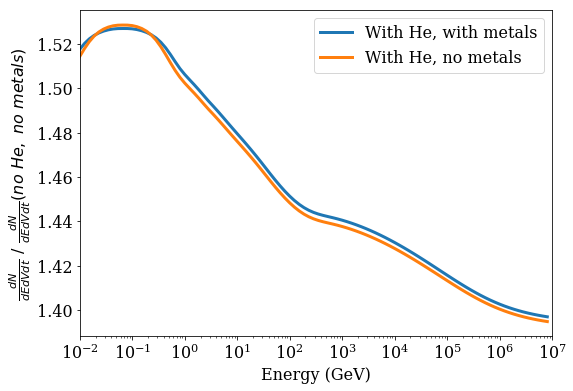

In [9]:
# Impact of the ICM metals
e = np.logspace(-2,7,100)*u.GeV
ctmp = copy.deepcopy(cluster)
r = 100*u.kpc

ctmp.abundance = 1.0
ctmp.helium_mass_fraction = 0.27
dNdEdVdt1 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.abundance = 0.0
ctmp.helium_mass_fraction = 0.27
dNdEdVdt2 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]
ctmp.abundance = 0.0
ctmp.helium_mass_fraction = 0.0
dNdEdVdt3 = ctmp.get_rate_gamma(energy=e,radius=r)[:,0]

plt.figure(figsize=(8,6))
plt.plot(e, dNdEdVdt1/dNdEdVdt3, label='With He, with metals', linewidth=3)
plt.plot(e, dNdEdVdt2/dNdEdVdt3, label='With He, no metals', linewidth=3)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{dN}{dEdVdt} \ / \ \frac{dN}{dEdVdt} (no \ He, \ no \ metals)$')
plt.xscale('log')
plt.xlim(1e-2, 1e7)
#plt.ylim(0.5,1.1)
plt.legend()
plt.savefig(figdir+'/prodrate3.pdf')

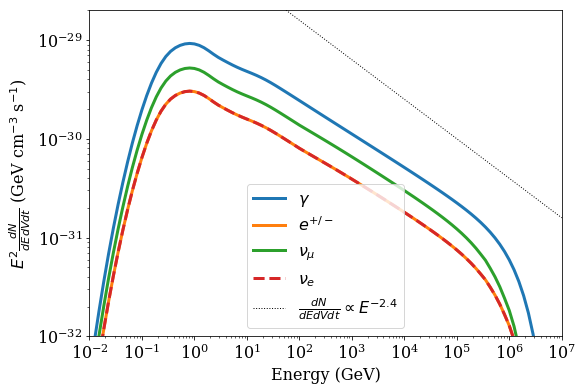

In [10]:
# Final result
e = np.logspace(-2,7,100)*u.GeV
r = 100*u.kpc

dNgdEdVdt = cluster.get_rate_gamma(energy=e,radius=r)[:,0]
dNedEdVdt = cluster.get_rate_cre2(energy=e,radius=r)[:,0]
dNnumudEdVdt = cluster.get_rate_neutrino(energy=e,radius=r,flavor='numu')[:,0]
dNnuedEdVdt = cluster.get_rate_neutrino(energy=e,radius=r,flavor='nue')[:,0]

plt.figure(figsize=(8,6))
plt.loglog(e, (e**2*dNgdEdVdt).to('GeV cm-3 s-1'), label='$\\gamma$', linewidth=3)
plt.loglog(e, (e**2*dNedEdVdt).to('GeV cm-3 s-1'), label='$e^{+/-}$', linewidth=3)
plt.loglog(e, (e**2*dNnumudEdVdt).to('GeV cm-3 s-1'), label='$\\nu_{\\mu}$', linewidth=3)
plt.loglog(e, (e**2*dNnuedEdVdt).to('GeV cm-3 s-1'), label='$\\nu_{e}$', linewidth=3, linestyle='--')
plt.loglog(e, 1e-28*(e**2*e**-cluster.spectrum_crp_model['Index']), label=r'$\frac{dN}{dEdVdt}\propto E^{-'+str(cluster.spectrum_crp_model['Index'])+'}$', linewidth=1, linestyle=':', color='k')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdVdt}$ (GeV cm$^{-3}$ s$^{-1}$)')
plt.xlim(1e-2, 1e7)
plt.ylim(1e-32, 2e-29)
plt.legend(loc='lower center')
plt.savefig(figdir+'/prodrate4.pdf')

# Electron energy loss

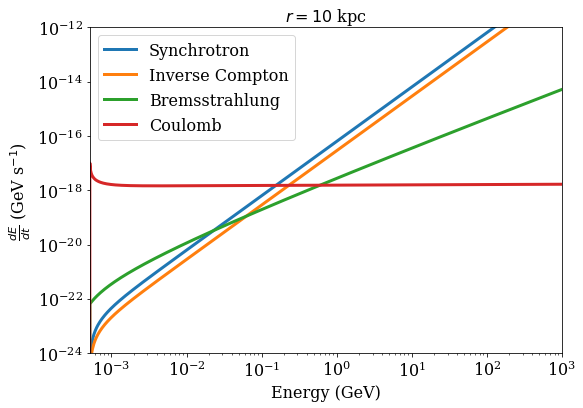

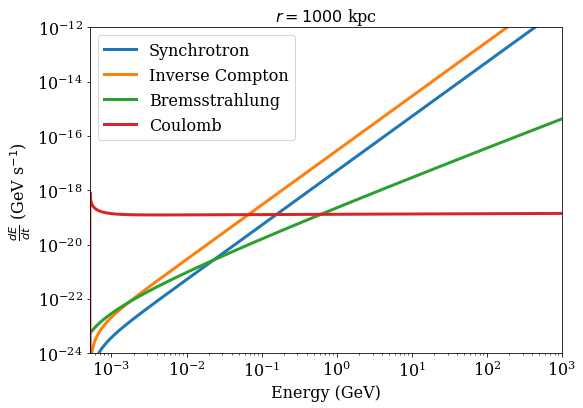

In [21]:
energy = np.logspace(-4, 5, 1000)*u.GeV

# ----- 10 kpc
B = (cluster.get_magfield_profile(10*u.kpc)[1])[0]
n_e = (cluster.get_density_gas_profile(10*u.kpc)[1])[0]

dEdt_sync = cel.dEdt_sync(energy, B)
dEdt_ic = cel.dEdt_ic(energy, cluster.redshift)
dEdt_brem = cel.dEdt_brem(energy, n_e)
dEdt_coul = cel.dEdt_coul(energy, n_e)

plt.figure(0, figsize=(8,6))
plt.loglog(energy, dEdt_sync, label='Synchrotron', linewidth=3)
plt.loglog(energy, dEdt_ic, label='Inverse Compton', linewidth=3)
plt.loglog(energy, dEdt_brem, label='Bremsstrahlung', linewidth=3)
plt.loglog(energy, dEdt_coul, label='Coulomb', linewidth=3)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{dE}{dt}$ (GeV s$^{-1}$)')
plt.title('$r = 10$ kpc')
plt.xlim((const.m_e*const.c**2).to_value('GeV'), 1e3)
plt.ylim(1e-24, 1e-12)
plt.legend()
plt.savefig(figdir+'/loss1.pdf')

# ----- 1000 kpc
B = (cluster.get_magfield_profile(1000*u.kpc)[1])[0]
n_e = (cluster.get_density_gas_profile(1000*u.kpc)[1])[0]

dEdt_sync = cel.dEdt_sync(energy, B)
dEdt_ic = cel.dEdt_ic(energy, cluster.redshift)
dEdt_brem = cel.dEdt_brem(energy, n_e)
dEdt_coul = cel.dEdt_coul(energy, n_e)

plt.figure(1, figsize=(8,6))
plt.loglog(energy, dEdt_sync, label='Synchrotron', linewidth=3)
plt.loglog(energy, dEdt_ic, label='Inverse Compton', linewidth=3)
plt.loglog(energy, dEdt_brem, label='Bremsstrahlung', linewidth=3)
plt.loglog(energy, dEdt_coul, label='Coulomb', linewidth=3)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{dE}{dt}$ (GeV s$^{-1}$)')
plt.title('$r = 1000$ kpc')
plt.xlim((const.m_e*const.c**2).to_value('GeV'), 1e3)
plt.ylim(1e-24, 1e-12)
plt.legend()
plt.savefig(figdir+'/loss2.pdf')

# Spectrum of CRe2

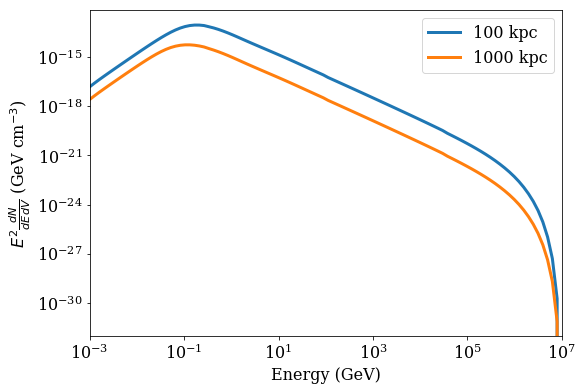

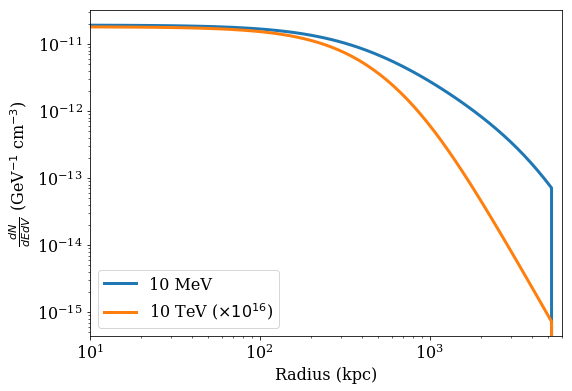

In [22]:
e = np.logspace(-3,7,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

ncre2_100 = cluster.get_cre2_2d(e,100*u.kpc)[:,0]
ncre2_1000 = cluster.get_cre2_2d(e,1000*u.kpc)[:,0]

plt.figure(0, figsize=(8,6))
plt.loglog(e, e**2*ncre2_100.to_value('GeV-1 cm-3'), linewidth=3, label='100 kpc')
plt.loglog(e, e**2*ncre2_1000.to_value('GeV-1 cm-3'), linewidth=3, label='1000 kpc')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdV}$ (GeV cm$^{-3}$)')
plt.xlim(1e-3, 1e7)
plt.legend()
plt.savefig(figdir+'/CRe2_spectra.pdf')

ncre2_10MeV = cluster.get_cre2_2d(10*u.MeV,r)[0,:]
ncre2_10TeV = cluster.get_cre2_2d(10*u.TeV, r)[0,:]

plt.figure(1, figsize=(8,6))
plt.loglog(r, ncre2_10MeV.to_value('GeV-1 cm-3'), linewidth=3, label='10 MeV')
plt.loglog(r, 1e16*ncre2_10TeV.to_value('GeV-1 cm-3'), linewidth=3, label='10 TeV ($\\times 10^{16}$)')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dEdV}$ (GeV$^{-1}$ cm$^{-3}$)')
plt.xlim(10, 6000)
plt.legend(loc='lower left')
plt.savefig(figdir+'/CRe2_profile.pdf')

# Effect of EBL

/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ebltable/tau_from_model.py:302: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)


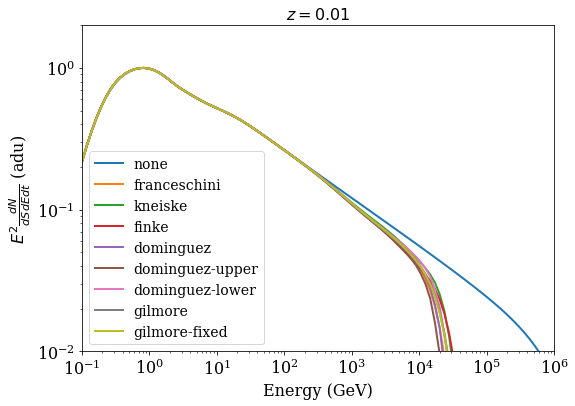

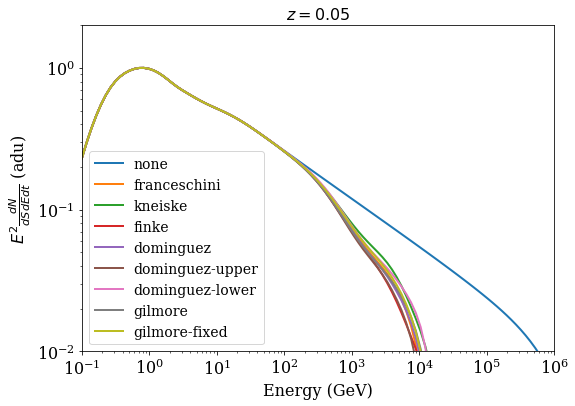

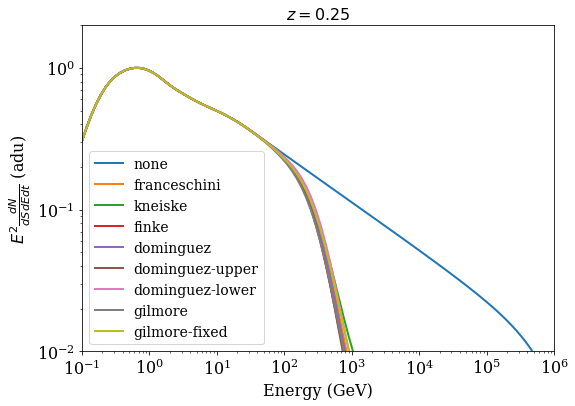

In [13]:
EBL_model = ['none', 'franceschini', 'kneiske', 'finke', 'dominguez', 'dominguez-upper', 'dominguez-lower', 'gilmore', 'gilmore-fixed']
energy = np.logspace(-1, 6, 100)*u.GeV
ctmp = copy.deepcopy(cluster)

plt.figure(0, figsize=(8,6))
for m in EBL_model:
    ctmp.redshift = 0.01
    ctmp.EBL_model = m
    e, S = ctmp.get_gamma_spectrum(energy)
    plt.loglog(e, e**2*S/np.amax((e**2*S).value), label=m, linewidth=2)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dSdEdt}$ (adu)')
plt.title('$z = 0.01$')
plt.xlim(1e-1, 1e6)
plt.ylim(1e-2, 2)
plt.legend(fontsize=14)
plt.savefig(figdir+'/ebl_impact1.pdf')

plt.figure(1, figsize=(8,6))
for m in EBL_model:
    ctmp.redshift = 0.05
    ctmp.EBL_model = m
    e, S = ctmp.get_gamma_spectrum(energy)
    plt.loglog(e, e**2*S/np.amax((e**2*S).value), label=m, linewidth=2)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dSdEdt}$ (adu)')
plt.title('$z = 0.05$')
plt.xlim(1e-1, 1e6)
plt.ylim(1e-2, 2)
plt.legend(fontsize=14)
plt.savefig(figdir+'/ebl_impact2.pdf')

plt.figure(2, figsize=(8,6))
for m in EBL_model:
    ctmp.redshift = 0.25
    ctmp.EBL_model = m
    e, S = ctmp.get_gamma_spectrum(energy)
    plt.loglog(e, e**2*S/np.amax((e**2*S).value), label=m, linewidth=2)
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dSdEdt}$ (adu)')
plt.title('$z = 0.25$')
plt.xlim(1e-1, 1e6)
plt.ylim(1e-2, 2)
plt.legend(fontsize=14)
plt.savefig(figdir+'/ebl_impact3.pdf')

# Observables

Flux:
('R500, sph', <Quantity 0.29150947 1 / (cm2 s)>)
('R500, cyl', <Quantity 0.30484296 1 / (cm2 s)>)
('Rtrunc, sph', <Quantity 0.33152809 1 / (cm2 s)>)
('Rtrunc, cyl', <Quantity 0.33059169 1 / (cm2 s)>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10


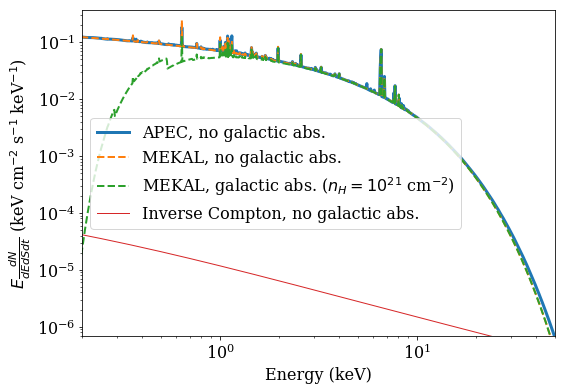

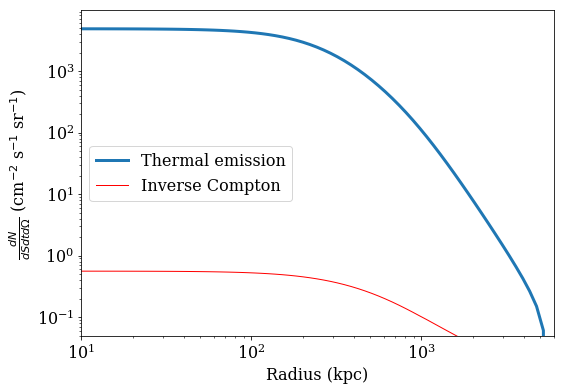

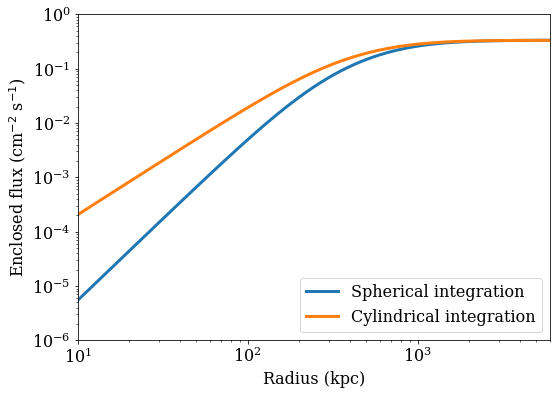

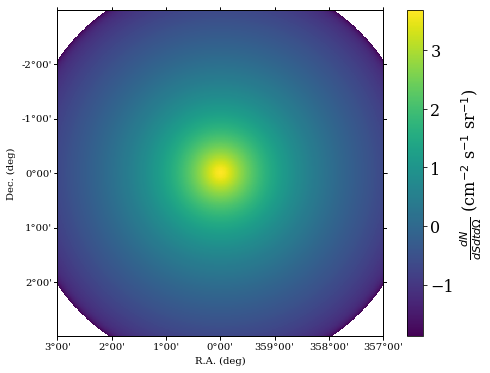

In [35]:
#---------- X-ray
E = np.linspace(0.1,50,1000)*u.keV
r = np.logspace(0,4,100)*u.kpc

# Make the table
ctmp.make_xspec_table(Emin=0.1*u.keV, Emax=2.4*u.keV, Tmin=0.1*u.keV, Tmax=50.0*u.keV, nbin=100,
                      nH=0.0/u.cm**2, file_HI=None, visu_nH=False,
                      model='APEC',
                      resp_file=None, data_file=None, app_nH_model=False)

#----- Spectrum
ctmp = copy.deepcopy(cluster)
e1, X1 = ctmp.get_xray_spectrum(E, model='APEC', nH=0.0*u.cm**-2, output_type='S')
e2, X2 = ctmp.get_xray_spectrum(E, model='MEKAL', nH=0.0*u.cm**-2, output_type='S')
e3, X3 = ctmp.get_xray_spectrum(E, model='MEKAL', nH=1.0*1e21*u.cm**-2, output_type='S')
E_ic, S_ic = ctmp.get_ic_spectrum(E)

plt.figure(0, figsize=(8,6))
plt.loglog(e1, X1.to_value('keV keV-1 s-1 cm-2'), linewidth=3, label='APEC, no galactic abs.')
plt.loglog(e2, X2.to_value('keV keV-1 s-1 cm-2'), linewidth=2, linestyle='--', label='MEKAL, no galactic abs.')
plt.loglog(e3, X3.to_value('keV keV-1 s-1 cm-2'), linewidth=2, linestyle='--', label='MEKAL, galactic abs. ($n_{H} = 10^{21}$ cm$^{-2}$)')
plt.loglog(E_ic, (E*S_ic).to_value('keV cm-2 s-1 keV-1'), linewidth=1, label='Inverse Compton, no galactic abs.')
plt.xlabel('Energy (keV)')
plt.ylabel(r'$E \frac{dN}{dEdSdt}$ (keV cm$^{-2}$ s$^{-1}$ keV$^{-1}$)')
plt.ylim(np.amin(X1.to_value('keV keV-1 s-1 cm-2')), np.amax(X1.to_value('keV keV-1 s-1 cm-2')*2))
plt.xlim(0.2, 50)
plt.legend()
plt.savefig(figdir+'/xray_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
X = ctmp.get_xray_profile(r)[1]
p_ic = ctmp.get_ic_profile(r, Emin=0.1*u.keV, Emax=2.4*u.keV)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, X.to('cm-2 s-1 sr-1'), linewidth=3, label='Thermal emission')
plt.loglog(r, p_ic.to('cm-2 s-1 sr-1'), linewidth=1, color='red', label='Inverse Compton')
plt.ylim(np.amax(X.to_value('cm-2 s-1 sr-1'))/1e5, np.amax(X.to_value('cm-2 s-1 sr-1'))*2)
plt.xlabel('Radius (kpc)')
plt.xlim(10, 6000)
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.legend()
plt.savefig(figdir+'/xray_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
X1 = ctmp.get_xray_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, output_type='C')
X2 = ctmp.get_xray_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, output_type='C')

plt.figure(2, figsize=(8,6))
plt.loglog(r, X1.to_value('s-1 cm-2'), linewidth=3, label='Spherical integration')
plt.loglog(r, X2.to_value('s-1 cm-2'), linewidth=3, label='Cylindrical integration')
plt.xlim(10, 6000)
plt.ylim(1e-6, 1)
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (cm$^{-2}$ s$^{-1}$)')
plt.legend()
plt.savefig(figdir+'/xray_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_xray_flux(Rmax=ctmp.R500, type_integral='spherical', Rmin=0.1*u.kpc, output_type='C'))
print('R500, cyl', ctmp.get_xray_flux(Rmax=ctmp.R500, type_integral='cylindrical', Rmin=0.1*u.kpc, output_type='C'))
print('Rtrunc, sph', ctmp.get_xray_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Rmin=0.1*u.kpc, output_type='C'))
print('Rtrunc, cyl', ctmp.get_xray_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Rmin=0.1*u.kpc, output_type='C'))

#----- Map
ctmp = copy.deepcopy(cluster)
X = ctmp.get_xray_map(output_type='C')

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(X.to_value('s-1 cm-2 sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.savefig(figdir+'/xray_map.pdf')

Flux:
('R500, sph', <Quantity [51.57065674] kpc2>)
('R500, cyl', <Quantity [67.43334678] kpc2>)
('Rtrunc, sph', <Quantity [130.68262382] kpc2>)
('Rtrunc, cyl', <Quantity [129.58097286] kpc2>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log10


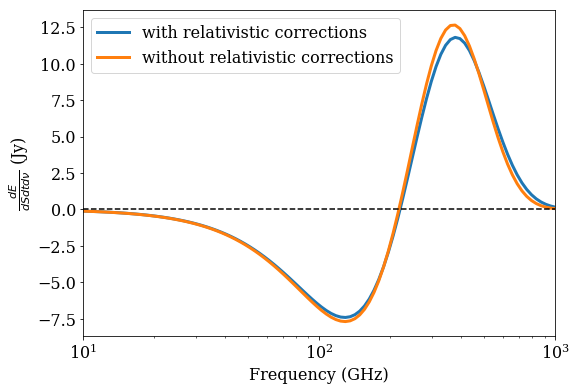

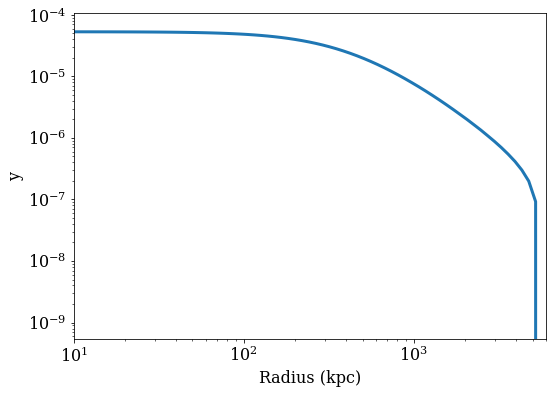

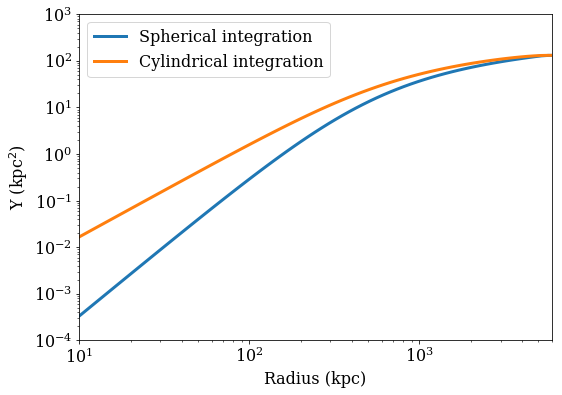

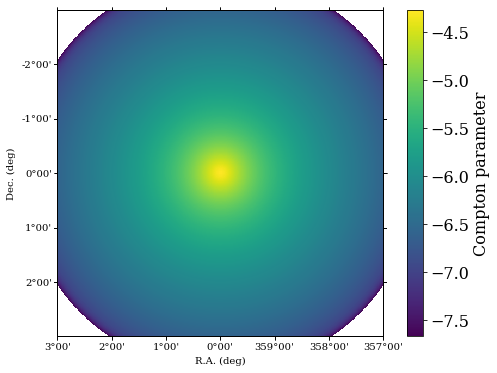

In [36]:
#---------- tSZ
f = np.logspace(1,3,100)*u.GHz
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
tSZ1 = ctmp.get_sz_spectrum(frequency=f, Compton_only=False)[1]
ctmp.density_gas_model = {'name':'beta', 'n_0':1e10*u.cm**-3, 'beta':0.6, 'r_c':100*u.kpc}
tSZ2 = ctmp.get_sz_spectrum(frequency=f, Compton_only=False)[1]

plt.figure(0, figsize=(8,6))
plt.plot(f, tSZ1.to_value('Jy'), linewidth=3, label='with relativistic corrections')
plt.plot(f, tSZ2.to_value('Jy'), linewidth=3, label='without relativistic corrections')
plt.plot(f, f*0, linestyle='--', color='k')
plt.xscale('log')
plt.xlim(10,1000)
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'$\frac{dE}{dSdtd\nu}$ (Jy)')
plt.legend()
plt.savefig(figdir+'/tSZ_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
tSZ = ctmp.get_sz_profile(r, Compton_only=True)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, tSZ.to_value('adu'), linewidth=3)
plt.ylim(np.amax(tSZ.to_value('adu'))/1e5, np.amax(tSZ.to_value('adu'))*2)
plt.xlabel('Radius (kpc)')
plt.ylabel('y')
plt.xlim(10, 6000)
plt.savefig(figdir+'/tSZ_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
tSZ1 = ctmp.get_sz_flux(Rmax=r, type_integral='spherical', Compton_only=True, Rmin=0.1*u.kpc)
tSZ2 = ctmp.get_sz_flux(Rmax=r, type_integral='cylindrical', Compton_only=True, Rmin=0.1*u.kpc)

plt.figure(2, figsize=(8,6))
plt.loglog(r, tSZ1.to_value('kpc2'), linewidth=3, label='Spherical integration')
plt.loglog(r, tSZ2.to_value('kpc2'), linewidth=3, label='Cylindrical integration')
plt.xlabel('Radius (kpc)')
plt.ylabel('Y (kpc$^2$)')
plt.xlim(10, 6000)
plt.ylim(1e-4, 1e3)
plt.legend()
plt.savefig(figdir+'/tSZ_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_sz_flux(Rmax=ctmp.R500, type_integral='spherical', Compton_only=True, Rmin=0.1*u.kpc))
print('R500, cyl', ctmp.get_sz_flux(Rmax=ctmp.R500, type_integral='cylindrical', Compton_only=True, Rmin=0.1*u.kpc))
print('Rtrunc, sph', ctmp.get_sz_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Compton_only=True, Rmin=0.1*u.kpc))
print('Rtrunc, cyl', ctmp.get_sz_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Compton_only=True, Rmin=0.1*u.kpc))

#----- Map
ctmp = copy.deepcopy(cluster)
tSZ = ctmp.get_sz_map(Compton_only=True)

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(tSZ.to_value('adu')), cmap='viridis')
cb = plt.colorbar()
cb.set_label('Compton parameter')
plt.savefig(figdir+'/tSZ_map.pdf')

Flux:
('R500, sph', <Quantity 7.38112039e-11 1 / (cm2 s)>)
('R500, cyl', <Quantity 8.0390214e-11 1 / (cm2 s)>)
('Rtrunc, sph', <Quantity 9.62930776e-11 1 / (cm2 s)>)
('Rtrunc, cyl', <Quantity 9.60006358e-11 1 / (cm2 s)>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log10


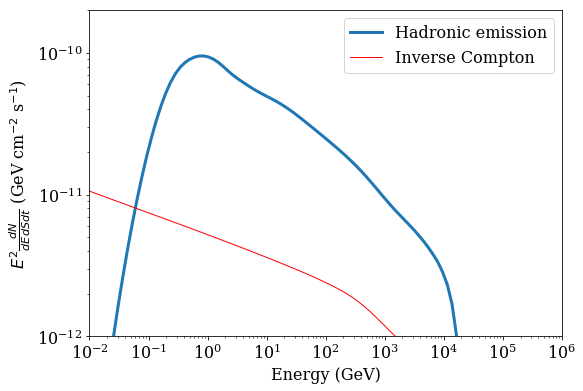

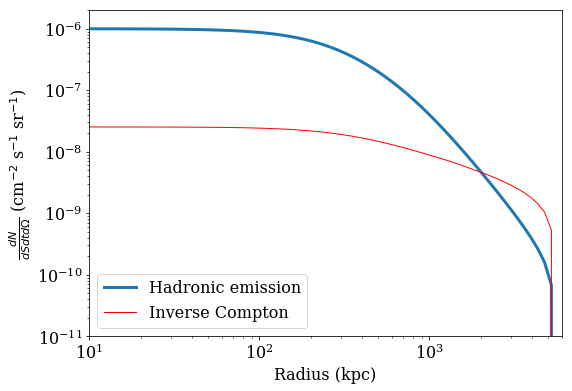

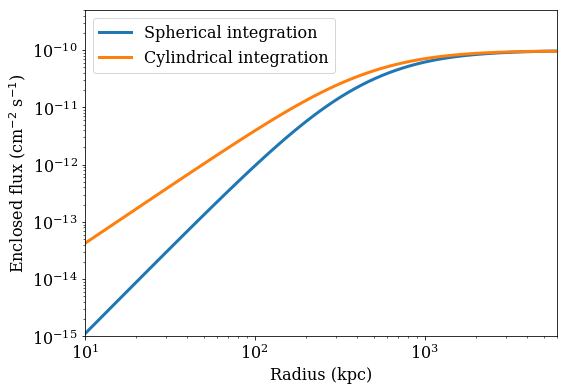

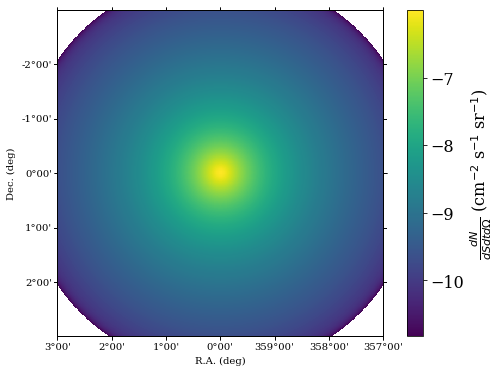

In [37]:
#---------- gamma
E = np.logspace(-2,6,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
g = ctmp.get_gamma_spectrum(E)[1]
ic = ctmp.get_ic_spectrum(E)[1]

plt.figure(0, figsize=(8,6))
plt.loglog(E, (E**2*g).to_value('GeV cm-2 s-1'), linewidth=3, label='Hadronic emission')
plt.loglog(E, (E**2*ic).to_value('GeV cm-2 s-1'), linewidth=1, color='red', label='Inverse Compton')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdSdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 1e6)
plt.ylim(1e-12, 2e-10)
plt.legend()
plt.savefig(figdir+'/gamma_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
g = ctmp.get_gamma_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
ic = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, g.to_value('cm-2 s-1 sr-1'), linewidth=3, label='Hadronic emission')
plt.loglog(r, ic.to_value('cm-2 s-1 sr-1'), linewidth=1, color='red', label='Inverse Compton')
plt.ylim(np.amax(g.to_value('cm-2 s-1 sr-1'))/1e5, np.amax(g.to_value('cm-2 s-1 sr-1'))*2)
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.xlim(10, 6000)
plt.legend()
plt.savefig(figdir+'/gamma_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
g1 = ctmp.get_gamma_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV)
g2 = ctmp.get_gamma_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV)

plt.figure(2, figsize=(8,6))
plt.loglog(r, g1.to_value('cm-2 s-1'), linewidth=3, label='Spherical integration')
plt.loglog(r, g2.to_value('cm-2 s-1'), linewidth=3, label='Cylindrical integration')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (cm$^{-2}$ s$^{-1}$)')
plt.xlim(10, 6000)
plt.ylim(1e-15, 5e-10)
plt.legend()
plt.savefig(figdir+'/gamma_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_gamma_flux(Rmax=ctmp.R500, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('R500, cyl', ctmp.get_gamma_flux(Rmax=ctmp.R500, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, sph', ctmp.get_gamma_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, cyl', ctmp.get_gamma_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))

#----- Map
ctmp = copy.deepcopy(cluster)
g = ctmp.get_gamma_map(Emin=1*u.GeV, Emax=1*u.TeV)

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(g.to_value('cm-2 s-1 sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.savefig(figdir+'/gamma_map.pdf')

Flux:
('R500, sph', <Quantity 6.59346805e-11 1 / (cm2 s)>)
('R500, cyl', <Quantity 7.18116329e-11 1 / (cm2 s)>)
('Rtrunc, sph', <Quantity 8.6017474e-11 1 / (cm2 s)>)
('Rtrunc, cyl', <Quantity 8.57562391e-11 1 / (cm2 s)>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10


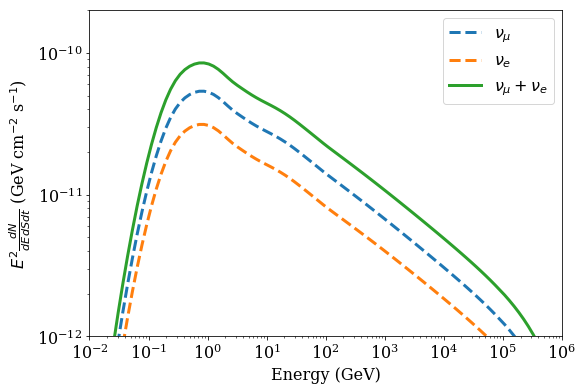

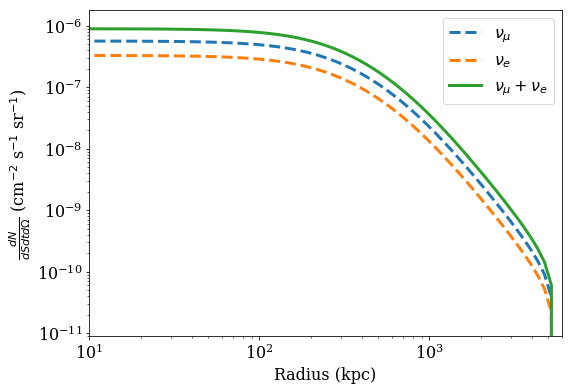

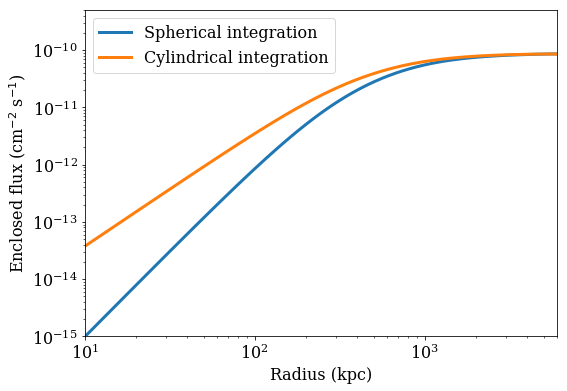

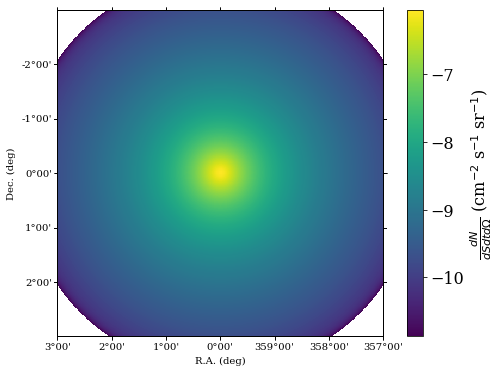

In [38]:
#---------- neutrinos
E = np.logspace(-2,6,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
n1 = ctmp.get_neutrino_spectrum(E, flavor='numu')[1]
n2 = ctmp.get_neutrino_spectrum(E, flavor='nue')[1]

plt.figure(0, figsize=(8,6))
plt.loglog(E, (E**2*n1).to_value('GeV cm-2 s-1'), linestyle='--',linewidth=3, label='$\\nu_{\\mu}$')
plt.loglog(E, (E**2*n2).to_value('GeV cm-2 s-1'), linestyle='--',linewidth=3, label='$\\nu_{e}$')
plt.loglog(E, (E**2*(n1+n2)).to_value('GeV cm-2 s-1'), linewidth=3, label='$\\nu_{\\mu}+\\nu_{e}$')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdSdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 1e6)
plt.ylim(1e-12, 2e-10)
plt.legend()
plt.savefig(figdir+'/nu_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
n1 = ctmp.get_neutrino_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False, flavor='numu')[1]
n2 = ctmp.get_neutrino_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False, flavor='nue')[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, n1.to_value('cm-2 s-1 sr-1'), linestyle='--', linewidth=3, label='$\\nu_{\\mu}$')
plt.loglog(r, n2.to_value('cm-2 s-1 sr-1'), linestyle='--', linewidth=3, label='$\\nu_{e}$')
plt.loglog(r, (n1+n2).to_value('cm-2 s-1 sr-1'), linewidth=3, label='$\\nu_{\\mu}+\\nu_{e}$')
plt.ylim(np.amax((n1+n2).to_value('cm-2 s-1 sr-1'))/1e5, np.amax((n1+n2).to_value('cm-2 s-1 sr-1'))*2)
plt.xlim(10, 6000)
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.legend()
plt.savefig(figdir+'/nu_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
n1 = ctmp.get_neutrino_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV, flavor='all')
n2 = ctmp.get_neutrino_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV, flavor='all')

plt.figure(2, figsize=(8,6))
plt.loglog(r, n1.to_value('cm-2 s-1'), linewidth=3, label='Spherical integration')
plt.loglog(r, n2.to_value('cm-2 s-1'), linewidth=3, label='Cylindrical integration')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (cm$^{-2}$ s$^{-1}$)')
plt.xlim(10, 6000)
plt.ylim(1e-15, 5e-10)
plt.legend()
plt.savefig(figdir+'/nu_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_neutrino_flux(Rmax=ctmp.R500, flavor='all',type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('R500, cyl', ctmp.get_neutrino_flux(Rmax=ctmp.R500, flavor='all',type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, sph', ctmp.get_neutrino_flux(Rmax=ctmp.R_truncation, flavor='all',type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, cyl', ctmp.get_neutrino_flux(Rmax=ctmp.R_truncation, flavor='all',type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))

#----- Map
ctmp = copy.deepcopy(cluster)
n = ctmp.get_neutrino_map(Emin=1*u.GeV, Emax=1*u.TeV, flavor='all')

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(n.to_value('cm-2 s-1 sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.savefig(figdir+'/nu_map.pdf')

Flux:
('R500, sph', <Quantity 4.50191307e-12 1 / (cm2 s)>)
('R500, cyl', <Quantity 8.26272442e-12 1 / (cm2 s)>)
('Rtrunc, sph', <Quantity 3.37612187e-11 1 / (cm2 s)>)
('Rtrunc, cyl', <Quantity 3.2968906e-11 1 / (cm2 s)>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10


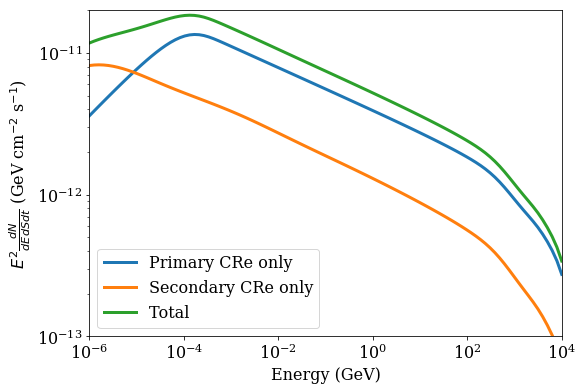

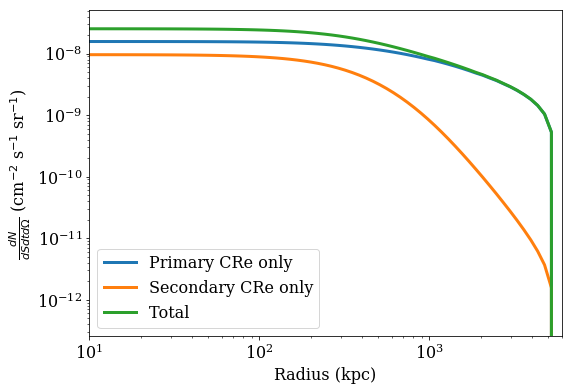

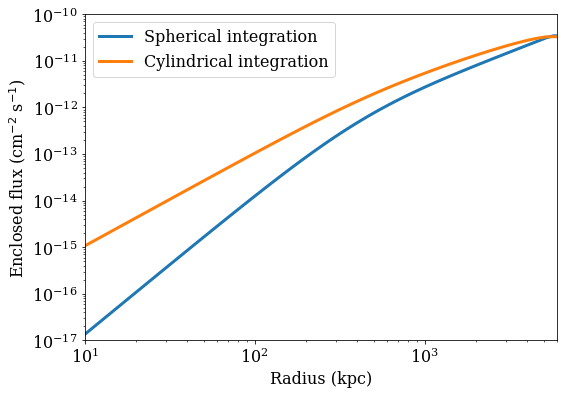

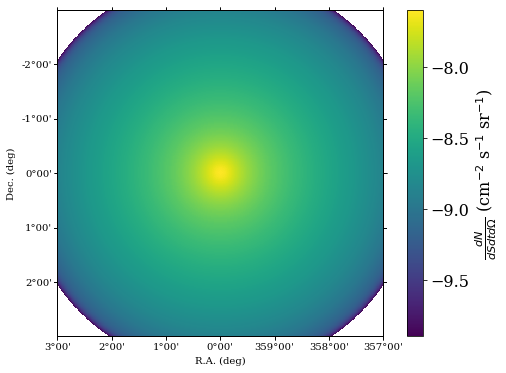

In [39]:
#---------- IC
E = np.logspace(-6,4,100)*u.GeV
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E  = {'X':0.00, 'R_norm':ctmp.R500}
g1 = ctmp.get_ic_spectrum(E)[1]
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
g2 = ctmp.get_ic_spectrum(E)[1]

plt.figure(0, figsize=(8,6))
plt.loglog(E, (E**2*g1).to_value('GeV cm-2 s-1'), linewidth=3, label='Primary CRe only')
plt.loglog(E, (E**2*g2).to_value('GeV cm-2 s-1'), linewidth=3, label='Secondary CRe only')
plt.loglog(E, (E**2*(g1+g2)).to_value('GeV cm-2 s-1'), linewidth=3, label='Total')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$E^2 \frac{dN}{dEdSdt}$ (GeV cm$^{-2}$ s$^{-1}$)')
plt.ylim(1e-13, 2e-11)
plt.xlim(1e-6, 1e4)
plt.legend()
plt.savefig(figdir+'/ic_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E  = {'X':0.00, 'R_norm':ctmp.R500}
g1 = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
g2 = ctmp.get_ic_profile(r, Emin=1*u.GeV, Emax=1*u.TeV, Energy_density=False)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, g1.to_value('cm-2 s-1 sr-1'), linewidth=3, label='Primary CRe only')
plt.loglog(r, g2.to_value('cm-2 s-1 sr-1'), linewidth=3, label='Secondary CRe only')
plt.loglog(r, (g1+g2).to_value('cm-2 s-1 sr-1'), linewidth=3, label='Total')
plt.ylim(np.amax((g1+g2).to_value('cm-2 s-1 sr-1'))/1e5, np.amax((g1+g2).to_value('cm-2 s-1 sr-1'))*2)
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.xlim(10, 6000)
plt.legend()
plt.savefig(figdir+'/ic_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
g1 = ctmp.get_ic_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV)
g2 = ctmp.get_ic_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=1*u.TeV)

plt.figure(2, figsize=(8,6))
plt.loglog(r, g1.to_value('cm-2 s-1'), linewidth=3, label='Spherical integration')
plt.loglog(r, g2.to_value('cm-2 s-1'), linewidth=3, label='Cylindrical integration')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (cm$^{-2}$ s$^{-1}$)')
plt.xlim(10, 6000)
plt.ylim(1e-17, 1e-10)
plt.legend()
plt.savefig(figdir+'/ic_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_ic_flux(Rmax=ctmp.R500, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('R500, cyl', ctmp.get_ic_flux(Rmax=ctmp.R500, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, sph', ctmp.get_ic_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))
print('Rtrunc, cyl', ctmp.get_ic_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Rmin=0.1*u.kpc, Emin=1*u.GeV, Emax=100*u.TeV))

#----- Map
ctmp = copy.deepcopy(cluster)
g = ctmp.get_ic_map(Emin=1*u.GeV, Emax=1*u.TeV)

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(g.to_value('cm-2 s-1 sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.savefig(figdir+'/ic_map.pdf')

Flux:
('R500, sph', <Quantity [1.07379293] Jy>)
('R500, cyl', <Quantity [1.14434348] Jy>)
('Rtrunc, sph', <Quantity [1.31316744] Jy>)
('Rtrunc, cyl', <Quantity [1.30908375] Jy>)


/Users/adam/Project/anaconda3/envs/fermi/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10


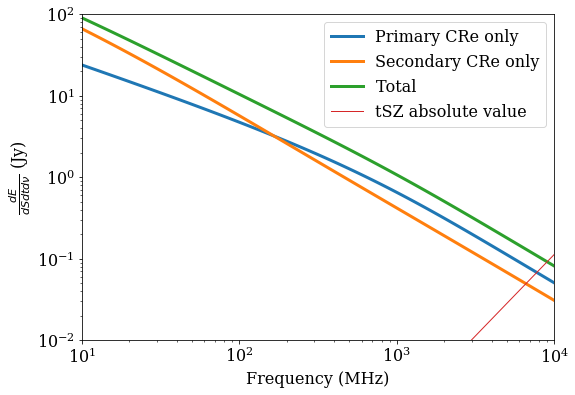

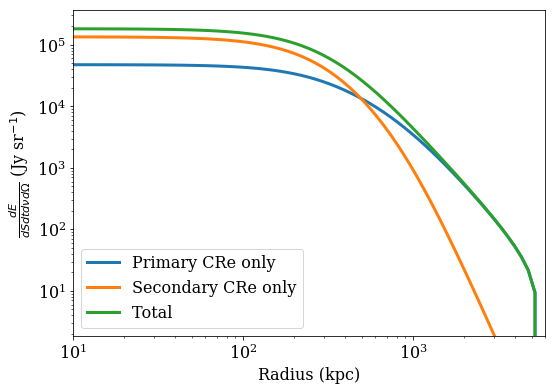

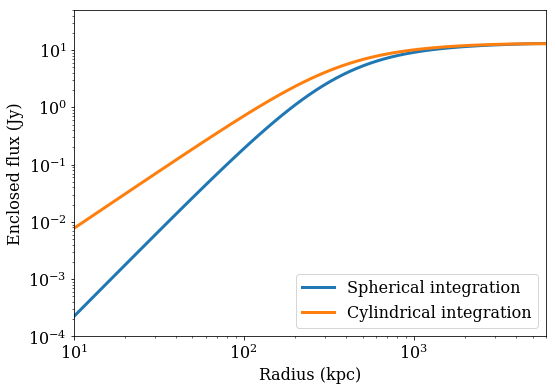

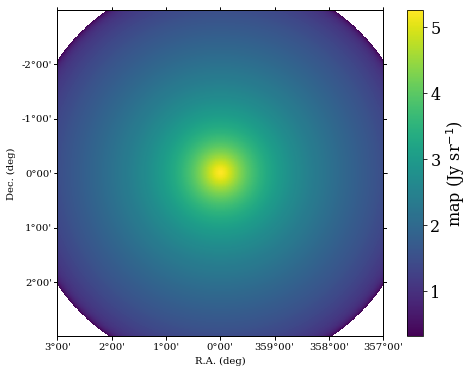

In [40]:
#---------- Synchrotron
f = np.logspace(1,4,100)*u.MHz
r = np.logspace(0,4,100)*u.kpc

#----- Spectrum
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E  = {'X':0.00, 'R_norm':ctmp.R500}
g1 = ctmp.get_synchrotron_spectrum(f)[1]
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
g2 = ctmp.get_synchrotron_spectrum(f)[1]

sz = ctmp.get_sz_spectrum(f, Compton_only=False)[1]

plt.figure(0, figsize=(8,6))
plt.loglog(f, g1.to_value('Jy'), linewidth=3, label='Primary CRe only')
plt.loglog(f, g2.to_value('Jy'), linewidth=3, label='Secondary CRe only')
plt.loglog(f, (g1+g2).to_value('Jy'), linewidth=3, label='Total')
plt.loglog(f, np.abs(sz.to_value('Jy')), linewidth=1, label='tSZ absolute value')
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'$\frac{dE}{dSdtd\nu}$ (Jy)')
plt.ylim(1e-2, 1e2)
plt.xlim(1e1, 1e4)
plt.legend()
plt.savefig(figdir+'/sync_spectra.pdf')

#----- Profile
ctmp = copy.deepcopy(cluster)
ctmp.X_crp_E  = {'X':0.00, 'R_norm':ctmp.R500}
g1 = ctmp.get_synchrotron_profile(r, freq0=100*u.MHz)[1]
ctmp = copy.deepcopy(cluster)
ctmp.X_cre1_E = {'X':0.00, 'R_norm':ctmp.R500}
g2 = ctmp.get_synchrotron_profile(r, freq0=100*u.MHz)[1]

plt.figure(1, figsize=(8,6))
plt.loglog(r, g1.to_value('Jy sr-1'), linewidth=3, label='Primary CRe only')
plt.loglog(r, g2.to_value('Jy sr-1'), linewidth=3, label='Secondary CRe only')
plt.loglog(r, (g1+g2).to_value('Jy sr-1'), linewidth=3, label='Total')
plt.ylim(np.amax((g1+g2).to_value('Jy sr-1'))/1e5, np.amax((g1+g2).to_value('Jy sr-1'))*2)
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dE}{dSdtd\nu d\Omega}$ (Jy sr$^{-1}$)')
plt.xlim(10, 6000)
plt.legend()
plt.savefig(figdir+'/sync_profile.pdf')

#----- Flux
ctmp = copy.deepcopy(cluster)
g1 = ctmp.get_synchrotron_flux(Rmax=r, type_integral='spherical', Rmin=0.1*u.kpc, freq0=100*u.MHz)
g2 = ctmp.get_synchrotron_flux(Rmax=r, type_integral='cylindrical', Rmin=0.1*u.kpc, freq0=100*u.MHz)

plt.figure(2, figsize=(8,6))
plt.loglog(r, g1.to_value('Jy'), linewidth=3, label='Spherical integration')
plt.loglog(r, g2.to_value('Jy'), linewidth=3, label='Cylindrical integration')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'Enclosed flux (Jy)')
plt.xlim(10, 6000)
plt.ylim(1e-4, 5e1)
plt.legend()
plt.savefig(figdir+'/sync_flux.pdf')

print('Flux:')
print('R500, sph', ctmp.get_synchrotron_flux(Rmax=ctmp.R500, type_integral='spherical', Rmin=0.1*u.kpc, freq0=1*u.GHz))
print('R500, cyl', ctmp.get_synchrotron_flux(Rmax=ctmp.R500, type_integral='cylindrical', Rmin=0.1*u.kpc, freq0=1*u.GHz))
print('Rtrunc, sph', ctmp.get_synchrotron_flux(Rmax=ctmp.R_truncation, type_integral='spherical', Rmin=0.1*u.kpc, freq0=1*u.GHz))
print('Rtrunc, cyl', ctmp.get_synchrotron_flux(Rmax=ctmp.R_truncation, type_integral='cylindrical', Rmin=0.1*u.kpc, freq0=1*u.GHz))

#----- Map
ctmp = copy.deepcopy(cluster)
g = ctmp.get_synchrotron_map(freq0=100*u.MHz)

plt.figure(3, figsize=(8,6))
ax = plt.subplot(111, projection=WCS(ctmp.get_map_header()))
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
plt.imshow(np.log10(g.to_value('Jy sr-1')), cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'map (Jy sr$^{-1}$)')
plt.savefig(figdir+'/sync_map.pdf')